In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets
# from pytorch_model_summary import summary

import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import glob
import gc
import time
from tqdm import tqdm
#from sklearn.model_selection import train_test_split
import cv2
#from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
torch.cuda.device_count()

1

In [4]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1,padding_mode='replicate', bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1,padding_mode='replicate', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)# not trainable
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)# trainable
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        #https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2),'replicate')
        x = torch.cat([x2, x1], dim=1)# concate on an axis
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)# point-wise conv

    def forward(self, x):
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        #self.down4 = (Down(512, 1024))#Question: why //factor fo decoding
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x = self.inc(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.up1(x4, x3)
        x6 = self.up2(x5, x2)
        x7 = self.up3(x6, x1)
        x8 = self.up4(x7, x)
        logits = self.outc(x8)
        return logits

#     def use_checkpointing(self):
#         self.inc = torch.utils.checkpoint(self.inc)
#         self.down1 = torch.utils.checkpoint(self.down1)
#         self.down2 = torch.utils.checkpoint(self.down2)
#         self.down3 = torch.utils.checkpoint(self.down3)
#         self.down4 = torch.utils.checkpoint(self.down4)
#         self.up1 = torch.utils.checkpoint(self.up1)
#         self.up2 = torch.utils.checkpoint(self.up2)
#         self.up3 = torch.utils.checkpoint(self.up3)
#         self.up4 = torch.utils.checkpoint(self.up4)
#         self.outc = torch.utils.checkpoint(self.outc)

In [6]:
def mapping_fn(val):
    if val == 0:
        return 0
    else:
        return 1

In [7]:
# Create a custom dataset from the image paths
class CustomDataset(data.Dataset):
    def __init__(self, image_paths,mask_paths, transform1=None,transform2=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, index):
        # Load the image and apply transforms
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('L')
        mask_path = self.mask_paths[index]
        mask = Image.open(mask_path).convert('L')
        if self.transform1 is not None:
            image = self.transform1(image).cuda()
            mask = self.transform2(mask).cuda()
        for j in range(len(mask)):
            for i in range(len(mask[j])):
                for z in range(len(mask[j][i])):
                    mask[j][i][z] = mapping_fn(mask[j][i][z])

        # Return the image and its corresponding index
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [8]:
# Define the transforms to be applied to the images
transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    transforms.Normalize((0,), (1/255,))
])

In [9]:
# Define the transforms to be applied to the images
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize((0,), (1/255,))
])

# For Getting paths-----------------------

In [9]:
import re
pattern = r'(\d+).tif'
def extract_numbers(s):
    string = str(s)
    match = re.search(pattern,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [21]:
import re
pattern_mask = r'(\d+)_mask.tif'
def extract_numbers_mask(s):
    string = str(s)
    match = re.search(pattern_mask,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [70]:
folder_path = './lgg-mri-segmentation/kaggle_3m'

# Create a Path object for the folder
#folder = pathlib.Path(folder_path)

# Get a list of all the file paths in the folder and its subdirectories
sub_folders = [f for f in pathlib.Path(folder_path).iterdir() if f.is_dir()]
original_image_lists = []
mask_image_lists = []
for sub_folder in sub_folders:
    image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and ("mask" not in str(pathlib.Path(f)))]
    mask_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and ("mask" in str(pathlib.Path(f)))]
    original_image_lists.extend(sorted(image_files,key=extract_numbers))
    mask_image_lists.extend(sorted(mask_image_files,key=extract_numbers_mask))

In [71]:
len(original_image_lists)

1359

In [72]:
len(mask_image_lists)

1359

In [66]:
type(extract_numbers_mask(mask_image_lists[0]))

int

In [67]:
extract_numbers(original_image_lists[0])

11

In [73]:
#.remove(element)
flag = False
for m in range(1359):
    for o in range(1359):
        if extract_numbers_mask(mask_image_lists[m]) == extract_numbers(original_image_lists[o]):
            flag = True
        #print(flag,o)
    print("m::::",m)
    if ~flag:
        must_delete_file=m
    flag = False

m:::: 0
m:::: 1
m:::: 2
m:::: 3
m:::: 4
m:::: 5
m:::: 6
m:::: 7
m:::: 8
m:::: 9
m:::: 10
m:::: 11
m:::: 12
m:::: 13
m:::: 14
m:::: 15
m:::: 16
m:::: 17
m:::: 18
m:::: 19
m:::: 20
m:::: 21
m:::: 22
m:::: 23
m:::: 24
m:::: 25
m:::: 26
m:::: 27
m:::: 28
m:::: 29
m:::: 30
m:::: 31
m:::: 32
m:::: 33
m:::: 34
m:::: 35
m:::: 36
m:::: 37
m:::: 38
m:::: 39
m:::: 40
m:::: 41
m:::: 42
m:::: 43
m:::: 44
m:::: 45
m:::: 46
m:::: 47
m:::: 48
m:::: 49
m:::: 50
m:::: 51
m:::: 52
m:::: 53
m:::: 54
m:::: 55
m:::: 56
m:::: 57
m:::: 58
m:::: 59
m:::: 60
m:::: 61
m:::: 62
m:::: 63
m:::: 64
m:::: 65
m:::: 66
m:::: 67
m:::: 68
m:::: 69
m:::: 70
m:::: 71
m:::: 72
m:::: 73
m:::: 74
m:::: 75
m:::: 76
m:::: 77
m:::: 78
m:::: 79
m:::: 80
m:::: 81
m:::: 82
m:::: 83
m:::: 84
m:::: 85
m:::: 86
m:::: 87
m:::: 88
m:::: 89
m:::: 90
m:::: 91
m:::: 92
m:::: 93
m:::: 94
m:::: 95
m:::: 96
m:::: 97
m:::: 98
m:::: 99
m:::: 100
m:::: 101
m:::: 102
m:::: 103
m:::: 104
m:::: 105
m:::: 106
m:::: 107
m:::: 108
m:::: 109
m:::: 110


m:::: 836
m:::: 837
m:::: 838
m:::: 839
m:::: 840
m:::: 841
m:::: 842
m:::: 843
m:::: 844
m:::: 845
m:::: 846
m:::: 847
m:::: 848
m:::: 849
m:::: 850
m:::: 851
m:::: 852
m:::: 853
m:::: 854
m:::: 855
m:::: 856
m:::: 857
m:::: 858
m:::: 859
m:::: 860
m:::: 861
m:::: 862
m:::: 863
m:::: 864
m:::: 865
m:::: 866
m:::: 867
m:::: 868
m:::: 869
m:::: 870
m:::: 871
m:::: 872
m:::: 873
m:::: 874
m:::: 875
m:::: 876
m:::: 877
m:::: 878
m:::: 879
m:::: 880
m:::: 881
m:::: 882
m:::: 883
m:::: 884
m:::: 885
m:::: 886
m:::: 887
m:::: 888
m:::: 889
m:::: 890
m:::: 891
m:::: 892
m:::: 893
m:::: 894
m:::: 895
m:::: 896
m:::: 897
m:::: 898
m:::: 899
m:::: 900
m:::: 901
m:::: 902
m:::: 903
m:::: 904
m:::: 905
m:::: 906
m:::: 907
m:::: 908
m:::: 909
m:::: 910
m:::: 911
m:::: 912
m:::: 913
m:::: 914
m:::: 915
m:::: 916
m:::: 917
m:::: 918
m:::: 919
m:::: 920
m:::: 921
m:::: 922
m:::: 923
m:::: 924
m:::: 925
m:::: 926
m:::: 927
m:::: 928
m:::: 929
m:::: 930
m:::: 931
m:::: 932
m:::: 933
m:::: 934
m:::: 935


In [74]:
len(mask_image_lists)

1359

In [75]:
df = pd.DataFrame([original_image_lists,mask_image_lists]) #Each list would be added as a row
df = df.transpose() #To Transpose and make each rows as columns
df.columns=['original_image','mask_image'] #Rename the columns

In [81]:
df.iloc[1000,0]

'lgg-mri-segmentation\\kaggle_3m\\TCGA_HT_7602_19951103\\TCGA_HT_7602_19951103_11.tif'

In [82]:
df.iloc[1000,1]

'lgg-mri-segmentation\\kaggle_3m\\TCGA_HT_7602_19951103\\TCGA_HT_7602_19951103_11_mask.tif'

In [83]:
df.to_csv("final_image_path.csv", index = False)

# Finished path getting

In [10]:
df_paths = pd.read_csv("final_image_path.csv")

In [11]:
df_paths.columns

Index(['original_image', 'mask_image'], dtype='object')

In [12]:
original_images = list(df_paths['original_image'])

In [13]:
len(original_images)

1359

In [14]:
mask_images = list(df_paths['mask_image'])

In [15]:
len(mask_images)

1359

In [16]:
# Create a custom dataset from the image paths
dataset = CustomDataset(original_images[:1000],mask_images[:1000], transform1,transform2)

In [17]:
dataset[1][1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [18]:
# Define the dataloader to load the images in batches
batch_size = 1

In [19]:
# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
#test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# define your UNet model
model = UNet(1,1,True).to(device)
# define your loss function
criterion = nn.BCEWithLogitsLoss()
# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(summary(model,torch.zeros((1,1,255,255)).cuda(), show_input=True))

--------------------------------------------------------------------------------------------
      Layer (type)                              Input Shape         Param #     Tr. Param #
      DoubleConv-1                         [1, 1, 255, 255]          37,568          37,568
            Down-2                        [1, 64, 255, 255]         221,440         221,440
            Down-3                       [1, 128, 127, 127]         885,248         885,248
            Down-4                         [1, 256, 63, 63]       3,539,968       3,539,968
            Down-5                         [1, 512, 31, 31]       4,719,616       4,719,616
              Up-6       [1, 512, 15, 15], [1, 512, 31, 31]       5,898,752       5,898,752
              Up-7       [1, 256, 31, 31], [1, 256, 63, 63]       1,474,816       1,474,816
              Up-8     [1, 128, 63, 63], [1, 128, 127, 127]         368,768         368,768
              Up-9     [1, 64, 127, 127], [1, 64, 255, 255]         110,720    

In [22]:
# train your model
loss_values = []
batch_passed = []
number = 0
for epoch in range(2):
    for images, masks in train_loader:
        number+=1
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss_values.append(loss)
        print(loss)
        print("number::::::::::",number)
        batch_passed.append(number)
        loss.backward()
        optimizer.step()

tensor(0.6764, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1
tensor(0.6253, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 2
tensor(0.5830, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 3
tensor(0.5979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 4
tensor(0.5377, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 5
tensor(0.5028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 6
tensor(0.5062, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 7
tensor(0.4622, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 8
tensor(0.4601, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 9
tensor(0.4086, device='cuda:0',
     

tensor(0.1242, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 77
tensor(0.1186, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 78
tensor(0.1341, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 79
tensor(0.1398, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 80
tensor(0.1256, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 81
tensor(0.1698, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 82
tensor(0.2967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 83
tensor(0.1839, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 84
tensor(0.1095, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 85
tensor(0.1479, device='cuda:

tensor(0.1055, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 153
tensor(0.0663, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 154
tensor(0.1656, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 155
tensor(0.1111, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 156
tensor(0.0659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 157
tensor(0.1474, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 158
tensor(0.0592, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 159
tensor(0.0720, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 160
tensor(0.0622, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 161
tensor(0.1221, devi

tensor(0.1583, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 229
tensor(0.2243, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 230
tensor(0.1710, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 231
tensor(0.0526, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 232
tensor(0.0702, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 233
tensor(0.0616, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 234
tensor(0.0804, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 235
tensor(0.0602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 236
tensor(0.0500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 237
tensor(0.0829, devi

tensor(0.0200, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 305
tensor(0.0255, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 306
tensor(0.2141, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 307
tensor(0.0636, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 308
tensor(0.0268, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 309
tensor(0.2226, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 310
tensor(0.2500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 311
tensor(0.0560, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 312
tensor(0.0692, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 313
tensor(0.0533, devi

tensor(0.0275, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 381
tensor(0.0925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 382
tensor(0.1021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 383
tensor(0.0472, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 384
tensor(0.1157, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 385
tensor(0.0523, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 386
tensor(0.0522, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 387
tensor(0.0993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 388
tensor(0.0498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 389
tensor(0.0544, devi

tensor(0.0510, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 457
tensor(0.1257, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 458
tensor(0.0764, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 459
tensor(0.0535, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 460
tensor(0.0520, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 461
tensor(0.0900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 462
tensor(0.0609, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 463
tensor(0.0625, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 464
tensor(0.0954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 465
tensor(0.1659, devi

tensor(0.0913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 533
tensor(0.0280, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 534
tensor(0.0688, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 535
tensor(0.1272, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 536
tensor(0.0752, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 537
tensor(0.1066, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 538
tensor(0.0838, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 539
tensor(0.1332, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 540
tensor(0.1215, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 541
tensor(0.0670, devi

tensor(0.0462, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 609
tensor(0.0784, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 610
tensor(0.0703, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 611
tensor(0.0575, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 612
tensor(0.0259, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 613
tensor(0.1801, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 614
tensor(0.1022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 615
tensor(0.0502, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 616
tensor(0.1191, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 617
tensor(0.0349, devi

tensor(0.0766, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 685
tensor(0.0675, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 686
tensor(0.0445, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 687
tensor(0.0203, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 688
tensor(0.0484, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 689
tensor(0.0209, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 690
tensor(0.0367, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 691
tensor(0.0960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 692
tensor(0.0297, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 693
tensor(0.0403, devi

tensor(0.0679, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 761
tensor(0.0333, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 762
tensor(0.0878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 763
tensor(0.0343, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 764
tensor(0.1827, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 765
tensor(0.0332, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 766
tensor(0.1924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 767
tensor(0.0410, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 768
tensor(0.0324, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 769
tensor(0.0910, devi

tensor(0.0789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 837
tensor(0.0474, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 838
tensor(0.0489, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 839
tensor(0.0604, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 840
tensor(0.0611, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 841
tensor(0.0562, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 842
tensor(0.0333, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 843
tensor(0.1158, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 844
tensor(0.1836, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 845
tensor(0.0398, devi

tensor(0.0395, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 913
tensor(0.0635, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 914
tensor(0.0544, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 915
tensor(0.1078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 916
tensor(0.0863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 917
tensor(0.0431, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 918
tensor(0.0498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 919
tensor(0.1840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 920
tensor(0.0464, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 921
tensor(0.0582, devi

tensor(0.0332, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 989
tensor(0.0662, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 990
tensor(0.0439, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 991
tensor(0.0368, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 992
tensor(0.0393, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 993
tensor(0.0561, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 994
tensor(0.0257, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 995
tensor(0.0897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 996
tensor(0.1272, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 997
tensor(0.0621, devi

tensor(0.0746, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1064
tensor(0.0333, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1065
tensor(0.0452, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1066
tensor(0.0245, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1067
tensor(0.0368, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1068
tensor(0.0370, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1069
tensor(0.1615, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1070
tensor(0.0378, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1071
tensor(0.0642, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1072
tensor(0.0

tensor(0.0429, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1139
tensor(0.0700, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1140
tensor(0.0456, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1141
tensor(0.0227, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1142
tensor(0.0247, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1143
tensor(0.0598, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1144
tensor(0.0450, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1145
tensor(0.0549, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1146
tensor(0.1136, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1147
tensor(0.0

tensor(0.0757, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1214
tensor(0.0821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1215
tensor(0.0444, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1216
tensor(0.0561, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1217
tensor(0.0554, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1218
tensor(0.0640, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1219
tensor(0.0524, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1220
tensor(0.0893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1221
tensor(0.0774, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1222
tensor(0.0

tensor(0.0361, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1289
tensor(0.0768, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1290
tensor(0.0294, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1291
tensor(0.0772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1292
tensor(0.1803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1293
tensor(0.0294, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1294
tensor(0.0264, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1295
tensor(0.0986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1296
tensor(0.0831, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1297
tensor(0.0

tensor(0.0223, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1364
tensor(0.0288, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1365
tensor(0.0634, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1366
tensor(0.0781, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1367
tensor(0.1248, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1368
tensor(0.0506, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1369
tensor(0.0433, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1370
tensor(0.0419, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1371
tensor(0.0391, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1372
tensor(0.0

tensor(0.0525, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1439
tensor(0.0656, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1440
tensor(0.0283, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1441
tensor(0.0667, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1442
tensor(0.0304, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1443
tensor(0.0239, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1444
tensor(0.1210, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1445
tensor(0.0225, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1446
tensor(0.0774, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1447
tensor(0.0

tensor(0.0184, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1514
tensor(0.0858, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1515
tensor(0.0508, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1516
tensor(0.1034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1517
tensor(0.0772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1518
tensor(0.0978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1519
tensor(0.0767, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1520
tensor(0.0269, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1521
tensor(0.1629, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1522
tensor(0.0

tensor(0.0989, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1589
tensor(0.0278, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1590
tensor(0.0158, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1591
tensor(0.1636, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1592
tensor(0.1338, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1593
tensor(0.0231, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1594
tensor(0.0750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1595
tensor(0.0688, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1596
tensor(0.0320, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
number:::::::::: 1597
tensor(0.0

In [23]:
torch.save(model.state_dict(), 'final_Unet_model.pth')

In [24]:
# validate your model
loss_val = []
with torch.no_grad():
    for images, masks in val_loader:
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss_val.append(loss)
        print("validation:",loss)

validation: tensor(0.0584, device='cuda:0')
validation: tensor(0.0419, device='cuda:0')
validation: tensor(0.0493, device='cuda:0')
validation: tensor(0.0514, device='cuda:0')
validation: tensor(0.0692, device='cuda:0')
validation: tensor(0.0527, device='cuda:0')
validation: tensor(0.0789, device='cuda:0')
validation: tensor(0.0276, device='cuda:0')
validation: tensor(0.0505, device='cuda:0')
validation: tensor(0.0433, device='cuda:0')
validation: tensor(0.0254, device='cuda:0')
validation: tensor(0.0477, device='cuda:0')
validation: tensor(0.0535, device='cuda:0')
validation: tensor(0.0258, device='cuda:0')
validation: tensor(0.0807, device='cuda:0')
validation: tensor(0.0370, device='cuda:0')
validation: tensor(0.0276, device='cuda:0')
validation: tensor(0.0568, device='cuda:0')
validation: tensor(0.0265, device='cuda:0')
validation: tensor(0.1336, device='cuda:0')
validation: tensor(0.0318, device='cuda:0')
validation: tensor(0.0268, device='cuda:0')
validation: tensor(0.0715, devic

validation: tensor(0.0265, device='cuda:0')
validation: tensor(0.1141, device='cuda:0')
validation: tensor(0.0229, device='cuda:0')
validation: tensor(0.0760, device='cuda:0')
validation: tensor(0.0265, device='cuda:0')
validation: tensor(0.0263, device='cuda:0')
validation: tensor(0.0176, device='cuda:0')
validation: tensor(0.0604, device='cuda:0')
validation: tensor(0.0591, device='cuda:0')
validation: tensor(0.0783, device='cuda:0')


KeyboardInterrupt: 

In [26]:
len(loss_val)

196

In [27]:
loss_val_numpy = [tensor.cpu().detach().numpy() for tensor in loss_values]

In [28]:
loss_val_numpy

[array(0.6763525, dtype=float32),
 array(0.62534714, dtype=float32),
 array(0.58300287, dtype=float32),
 array(0.59792346, dtype=float32),
 array(0.5377307, dtype=float32),
 array(0.50282204, dtype=float32),
 array(0.5061929, dtype=float32),
 array(0.46224213, dtype=float32),
 array(0.46012124, dtype=float32),
 array(0.40864122, dtype=float32),
 array(0.409123, dtype=float32),
 array(0.40046424, dtype=float32),
 array(0.41083905, dtype=float32),
 array(0.39170992, dtype=float32),
 array(0.3834746, dtype=float32),
 array(0.3561871, dtype=float32),
 array(0.36377668, dtype=float32),
 array(0.3986853, dtype=float32),
 array(0.32083493, dtype=float32),
 array(0.35627836, dtype=float32),
 array(0.3118317, dtype=float32),
 array(0.3061457, dtype=float32),
 array(0.3273059, dtype=float32),
 array(0.27443177, dtype=float32),
 array(0.29656315, dtype=float32),
 array(0.2561885, dtype=float32),
 array(0.27349687, dtype=float32),
 array(0.3225284, dtype=float32),
 array(0.25938278, dtype=float32)

Text(0.5, 1.0, 'Plot of Training Losses')

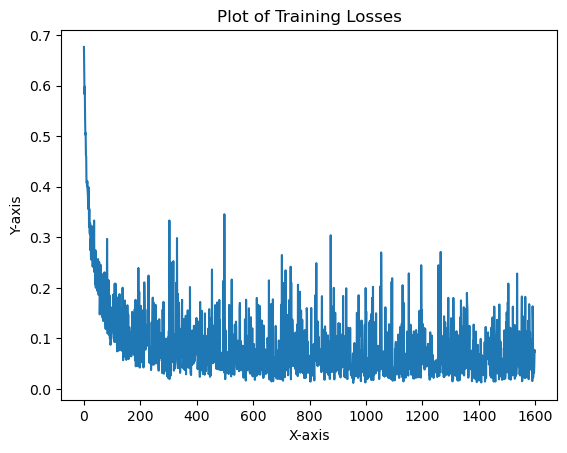

In [35]:
plt.plot(loss_val_numpy)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Training Losses')

In [36]:
loss_val_validation_numpy = [tensor.cpu().detach().numpy() for tensor in loss_val]

Text(0.5, 1.0, 'Plot of Validation Losses')

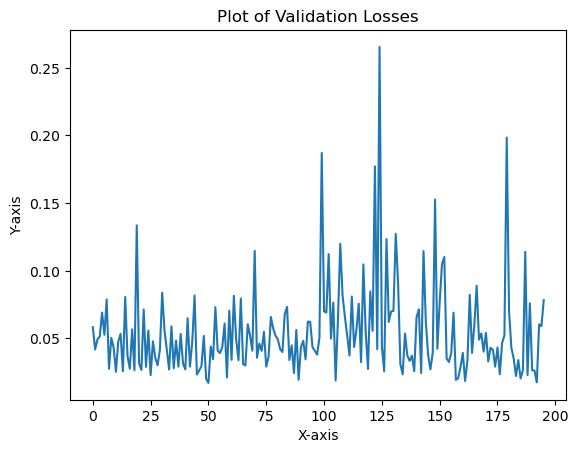

In [37]:
plt.plot(loss_val_validation_numpy)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Validation Losses')

In [38]:
# Save the list of NumPy arrays to a file
np.save('Training_Losses.npy', loss_val_numpy)
np.save('Validation_Losses.npy', loss_val_validation_numpy)

In [38]:
def calculate_iou(pred_mask, gt_mask):
    intersection = torch.logical_and(pred_mask, gt_mask)
    union = torch.logical_or(pred_mask, gt_mask)
    iou = torch.sum(intersection).item() / torch.sum(union).item()
    return iou

In [69]:
test_or_path = pathlib.Path('lgg-mri-segmentation\\test\\TCGA_HT_A616_19991226\\TCGA_HT_A616_19991226_17.tif')

In [70]:
str(test_or_path)

'lgg-mri-segmentation\\test\\TCGA_HT_A616_19991226\\TCGA_HT_A616_19991226_17.tif'

In [71]:
test_mask_path = pathlib.Path('lgg-mri-segmentation\\test\\TCGA_HT_A616_19991226\\TCGA_HT_A616_19991226_17_mask.tif')

In [72]:
str(test_mask_path)

'lgg-mri-segmentation\\test\\TCGA_HT_A616_19991226\\TCGA_HT_A616_19991226_17_mask.tif'

In [73]:
test_dataset = CustomDataset([str(test_or_path)],[str(test_mask_path)], transform1,transform2)

In [74]:
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [39]:
# Apply a threshold to obtain the binary segmentation mask
threshold = 0.1
#binary_mask = (output > threshold).float()

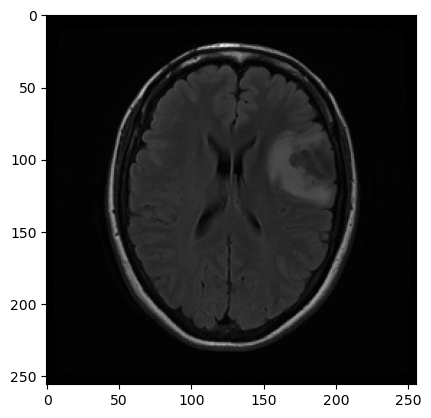

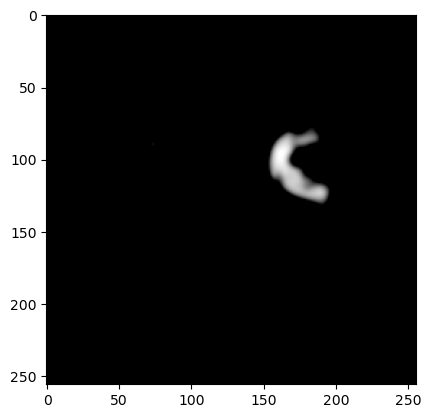

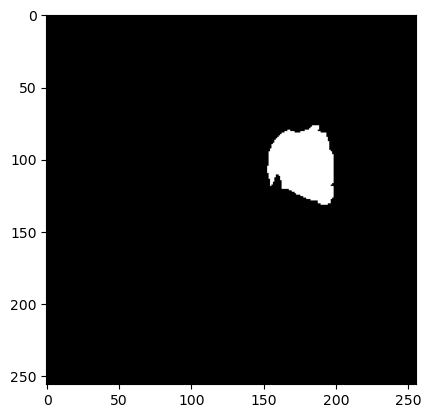

In [76]:
ev = []
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        # evaluate performance on test set
        iou_scores = []
        for i in range(outputs.shape[0]):
            plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
            # Save the image to a file
            plt.imsave('image{}{}.png'.format(images[i].shape[0],i), np.squeeze(images[i].cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()), cmap='gray')
            plt.imsave('outputs{}{}.png'.format(outputs[i].shape[0],i), np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(masks[i].cpu().numpy()), cmap='gray')
            plt.imsave('masks{}{}.png'.format(masks[i].shape[0],i), np.squeeze(masks[i].cpu().numpy()))
            plt.show()
            iou = calculate_iou(F.threshold(outputs[i],threshold, 0), masks[i])
            iou_scores.append(iou)
        ev.extend(iou_scores)

In [77]:
ev[0]

0.5627931214174049

For Azad University testing:

In [46]:
test_or_path = pathlib.Path('test03.tiff')

In [47]:
test_mask_path = pathlib.Path('test03_mask.png')

In [48]:
test_dataset = CustomDataset([str(test_or_path)],[str(test_mask_path)], transform1,transform2)

In [49]:
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
# define your UNet model
model = UNet(1,1,True).to(device)
# define your loss function
criterion = nn.BCEWithLogitsLoss()
# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load("final_Unet_model.pth"))

<All keys matched successfully>

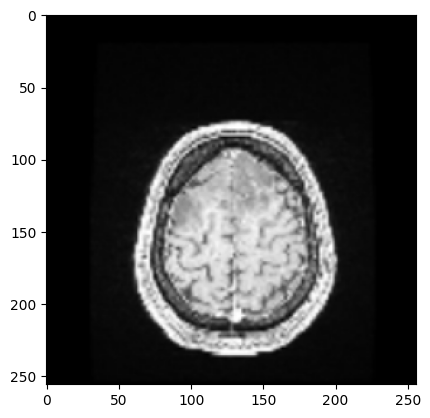

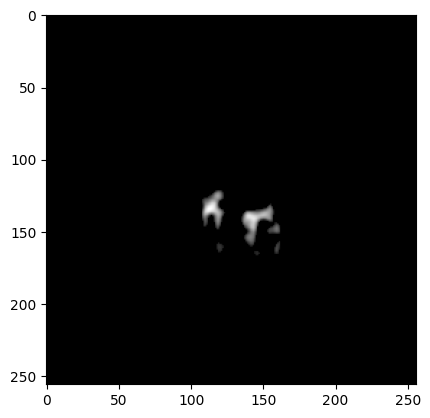

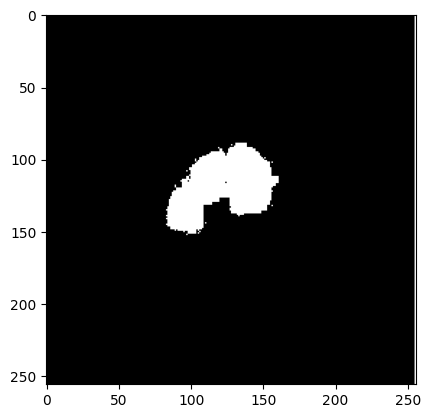

In [50]:
ev = []
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        # evaluate performance on test set
        iou_scores = []
        for i in range(outputs.shape[0]):
            plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
            # Save the image to a file
            plt.imsave('image{}{}.png'.format(images[i].shape[0],i), np.squeeze(images[i].cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()), cmap='gray')
            plt.imsave('outputs{}{}.png'.format(outputs[i].shape[0],i), np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(masks[i].cpu().numpy()), cmap='gray')
            plt.imsave('masks{}{}.png'.format(masks[i].shape[0],i), np.squeeze(masks[i].cpu().numpy()))
            plt.show()
            iou = calculate_iou(F.threshold(outputs[i],threshold, 0), masks[i])
            iou_scores.append(iou)
        ev.extend(iou_scores)